# Programming Assignment 1: Data Preparation and Understanding


## 1. Stanford Dogs Dataset


### a) Assigned Classes

The following 4 classes have been assigned for this assignment:

- n02089078-black-and-tan_coonhound

- n02091831-Saluki

- n02092002-Scottish_deerhound

- n02095314-wire-haired_fox_terrier


### b) Download Images and Annotations


### c) GitHub Repository

The solution, including README, code, and processed dataset, will be shared with
the grader via a GitHub repository.


## 2. Image Processing and Feature Extraction


In [21]:
# %%
import os
import xml.etree.ElementTree as ET
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import exposure, filters, io
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


In [22]:
class DirectoryPaths:
    BASE_IMAGE_DIR = "./Dataset/Images"
    BASE_ANNOTATION_DIR = "./Dataset/Annotation"
    PROCESSED_OUTPUT_DIR = "./Processed"
    GRAYSCALE_OUTPUT_DIR = "./Grayscale"
    EDGE_HISTOGRAM_OUTPUT_DIR = "./EdgeHistogram"


class DogBreedClasses:
    BREED_CLASSES = [
        "n02089078-black-and-tan_coonhound",
        "n02091831-Saluki",
        "n02092002-Scottish_deerhound",
        "n02095314-wire-haired_fox_terrier",
    ]

    @staticmethod
    def get_breed_labels():
        return [
            breed_class.split("-")[-1] for breed_class in DogBreedClasses.BREED_CLASSES
        ]

### a) Cropping and Resizing Images


In [23]:
class ImagePreprocessor:
    @staticmethod
    def extract_bounding_boxes(annotation_file):
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        objects = root.findall("object")
        bounding_boxes = []
        for obj in objects:
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            bounding_boxes.append((xmin, ymin, xmax, ymax))
        return bounding_boxes

    @staticmethod
    def process_and_save_image(image_path, annotation_path, output_directory):
        image = Image.open(image_path)
        bounding_boxes = ImagePreprocessor.extract_bounding_boxes(annotation_path)
        for idx, bbox in enumerate(bounding_boxes):
            cropped_image = image.crop(bbox)
            resized_image = cropped_image.resize((128, 128), Image.Resampling.LANCZOS)
            output_filename = os.path.basename(image_path).replace(
                ".jpg", f"_{idx}.jpg"
            )
            output_path = os.path.join(output_directory, output_filename)
            resized_image.convert("RGB").save(output_path)


for dog_breed in DogBreedClasses.BREED_CLASSES:
    breed_image_dir = os.path.join(DirectoryPaths.BASE_IMAGE_DIR, dog_breed)
    breed_annotation_dir = os.path.join(DirectoryPaths.BASE_ANNOTATION_DIR, dog_breed)
    breed_output_dir = os.path.join(DirectoryPaths.PROCESSED_OUTPUT_DIR, dog_breed)

    Path(breed_output_dir).mkdir(parents=True, exist_ok=True)

    for image_file in os.listdir(breed_image_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(breed_image_dir, image_file)
            annotation_file = os.path.join(
                breed_annotation_dir, image_file.replace(".jpg", "")
            )

            if os.path.exists(annotation_file):
                ImagePreprocessor.process_and_save_image(
                    image_path, annotation_file, breed_output_dir
                )
            else:
                print(f"Annotation file not found for {image_file}, skipping.")


### b) Feature Extraction: Edge Histogram and Similarity Measurements


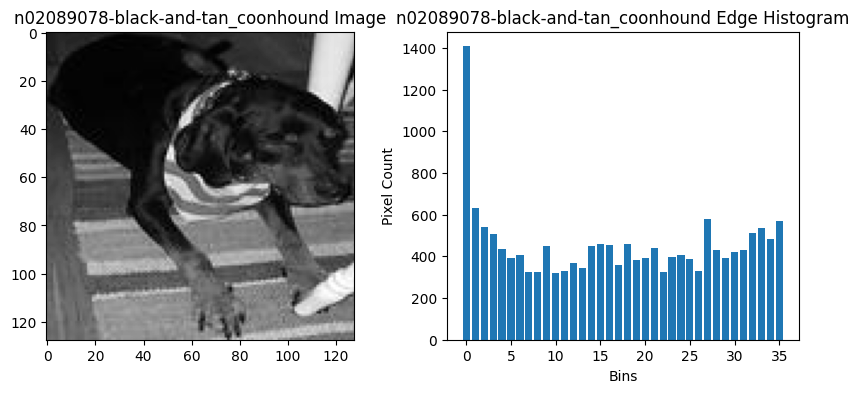

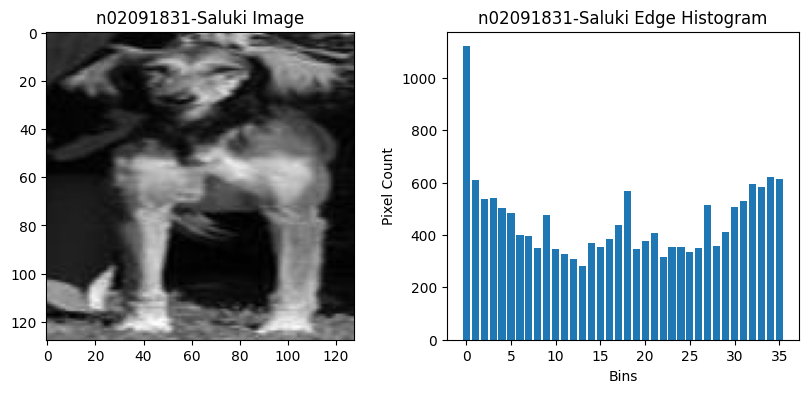

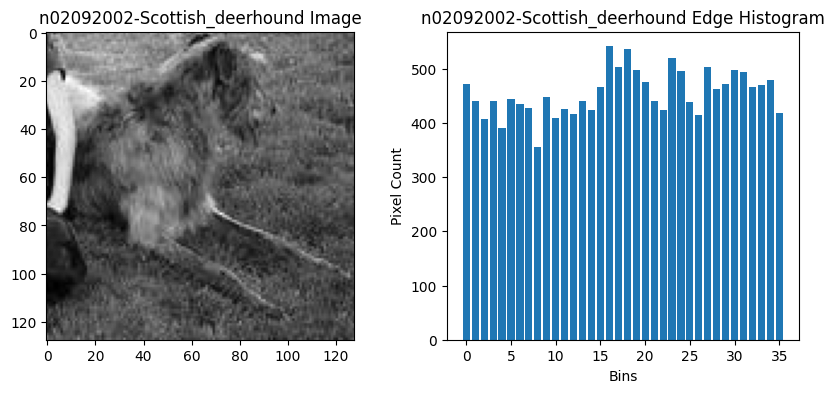

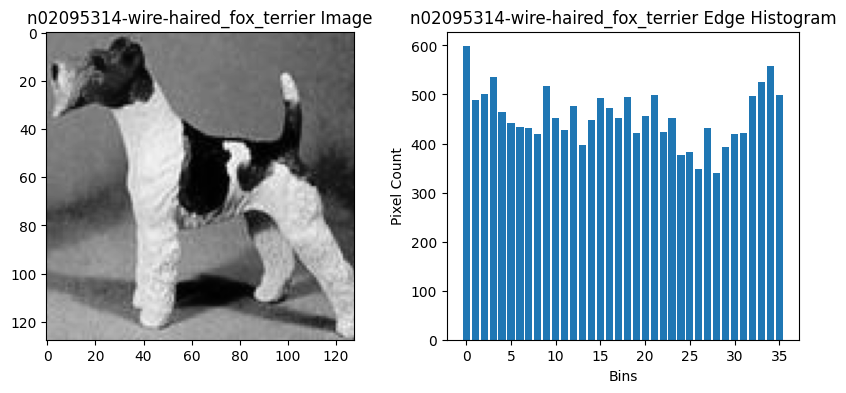

Comparing edge histograms of n02089078-black-and-tan_coonhound and n02091831-Saluki
Euclidean distance: 466.81688058595313
Manhattan distance: 2136.0
Cosine distance: 0.012718539460150557


In [24]:
class FeatureExtractor:
    @staticmethod
    def convert_to_grayscale_and_save(image_path, output_directory):
        image = Image.open(image_path)
        grayscale_image = image.convert("L")
        grayscale_path = os.path.join(output_directory, os.path.basename(image_path))
        grayscale_image.save(grayscale_path)
        return np.array(grayscale_image)

    @staticmethod
    def calculate_edge_angle(grayscale_image):
        sobel_horizontal = filters.sobel_h(grayscale_image)
        sobel_vertical = filters.sobel_v(grayscale_image)
        edge_angle = np.mod(np.arctan2(sobel_vertical, sobel_horizontal), np.pi)
        return edge_angle

    @staticmethod
    def compute_edge_histogram(edge_angle):
        histogram, histogram_centers = exposure.histogram(edge_angle, nbins=36)
        return histogram, histogram_centers

    @staticmethod
    def plot_histogram(image, histogram, class_name):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"{class_name} Image")

        plt.subplot(1, 2, 2)
        plt.bar(range(len(histogram)), histogram)
        plt.xlabel("Bins")
        plt.ylabel("Pixel Count")
        plt.title(f"{class_name} Edge Histogram")
        plt.show()

    @staticmethod
    def compare_histograms(histogram1, histogram2):
        histogram1 = histogram1.reshape(1, -1)
        histogram2 = histogram2.reshape(1, -1)
        euclidean_distance = pairwise_distances(
            histogram1, histogram2, metric="euclidean"
        )[0][0]
        manhattan_distance = pairwise_distances(
            histogram1, histogram2, metric="manhattan"
        )[0][0]
        cosine_distance = pairwise_distances(histogram1, histogram2, metric="cosine")[
            0
        ][0]

        return euclidean_distance, manhattan_distance, cosine_distance


histograms = []
class_names = []


for dog_breed in DogBreedClasses.BREED_CLASSES:
    breed_image_dir = os.path.join(DirectoryPaths.PROCESSED_OUTPUT_DIR, dog_breed)
    breed_output_dir = os.path.join(DirectoryPaths.GRAYSCALE_OUTPUT_DIR, dog_breed)
    Path(breed_output_dir).mkdir(parents=True, exist_ok=True)

    for image_file in os.listdir(breed_image_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(breed_image_dir, image_file)
            FeatureExtractor.convert_to_grayscale_and_save(image_path, breed_output_dir)

    image_file = os.listdir(breed_image_dir)[0]
    image_path = os.path.join(breed_image_dir, image_file)

    grayscale_image = FeatureExtractor.convert_to_grayscale_and_save(
        image_path, breed_output_dir
    )
    edge_angle = FeatureExtractor.calculate_edge_angle(grayscale_image)
    histogram, histogram_centers = FeatureExtractor.compute_edge_histogram(edge_angle)

    histograms.append(histogram)
    class_names.append(dog_breed)

    FeatureExtractor.plot_histogram(grayscale_image, histogram, dog_breed)

histogram1, histogram2 = histograms[0], histograms[1]
class1, class2 = class_names[0], class_names[1]

print(f"Comparing edge histograms of {class1} and {class2}")

euclidean_distance, manhattan_distance, cosine_distance = (
    FeatureExtractor.compare_histograms(histogram1, histogram2)
)

print(f"Euclidean distance: {euclidean_distance}")
print(f"Manhattan distance: {manhattan_distance}")
print(f"Cosine distance: {cosine_distance}")


In [25]:
class EdgeHistogramProcessor:
    @staticmethod
    def process_and_save_edge_histograms(grayscale_dir, output_dir):
        image_count = 0
        for image_file in os.listdir(grayscale_dir):
            if image_file.endswith(".jpg"):
                image_path = os.path.join(grayscale_dir, image_file)
                grayscale_image = np.array(Image.open(image_path))

                edge_angle = FeatureExtractor.calculate_edge_angle(grayscale_image)
                histogram, _ = FeatureExtractor.compute_edge_histogram(edge_angle)

                output_path = os.path.join(
                    output_dir, image_file.replace(".jpg", "_histogram.npy")
                )
                np.save(output_path, histogram)
                image_count += 1

        return image_count


total_processed = 0

for dog_breed in DogBreedClasses.BREED_CLASSES:
    breed_grayscale_dir = os.path.join(DirectoryPaths.GRAYSCALE_OUTPUT_DIR, dog_breed)
    breed_histogram_dir = os.path.join(
        DirectoryPaths.EDGE_HISTOGRAM_OUTPUT_DIR, dog_breed
    )
    Path(breed_histogram_dir).mkdir(parents=True, exist_ok=True)

    processed_count = EdgeHistogramProcessor.process_and_save_edge_histograms(
        breed_grayscale_dir, breed_histogram_dir
    )

    total_processed += processed_count
    print(f"Processed {processed_count} images for breed {dog_breed}")

print(f"\nTotal images processed: {total_processed}")


Processed 159 images for breed n02089078-black-and-tan_coonhound
Processed 223 images for breed n02091831-Saluki
Processed 246 images for breed n02092002-Scottish_deerhound
Processed 166 images for breed n02095314-wire-haired_fox_terrier

Total images processed: 794


### c) Histogram of Oriented Gradient (HOG) Feature Descriptor


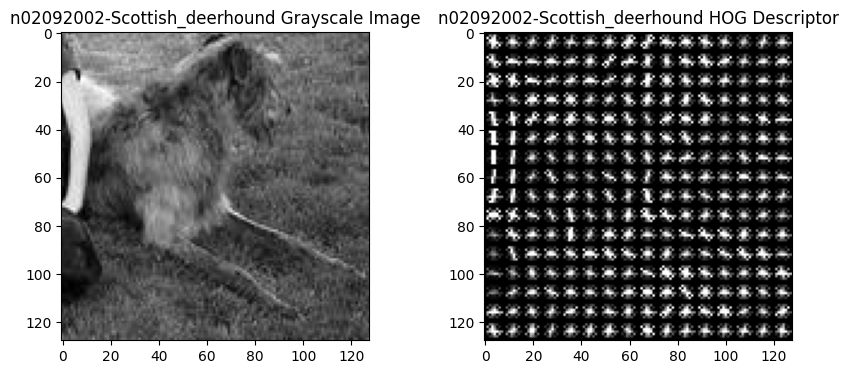

In [26]:
class HOGVisualizer:
    @staticmethod
    def compute_and_visualize_hog(grayscale_image, class_name):
        hog_features, hog_image = hog(
            grayscale_image,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            block_norm="L2-Hys",
        )

        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(grayscale_image, cmap="gray")
        plt.title(f"{class_name} Grayscale Image")

        plt.subplot(1, 2, 2)
        plt.imshow(hog_image_rescaled, cmap="gray")
        plt.title(f"{class_name} HOG Descriptor")
        plt.show()


selected_breed = "n02092002-Scottish_deerhound"
breed_image_dir = os.path.join(DirectoryPaths.GRAYSCALE_OUTPUT_DIR, selected_breed)

image_file = os.listdir(breed_image_dir)[0]
grayscale_image_path = os.path.join(breed_image_dir, image_file)

grayscale_image = io.imread(grayscale_image_path)

HOGVisualizer.compute_and_visualize_hog(grayscale_image, selected_breed)


### d) Dimensionality Reduction (PCA)


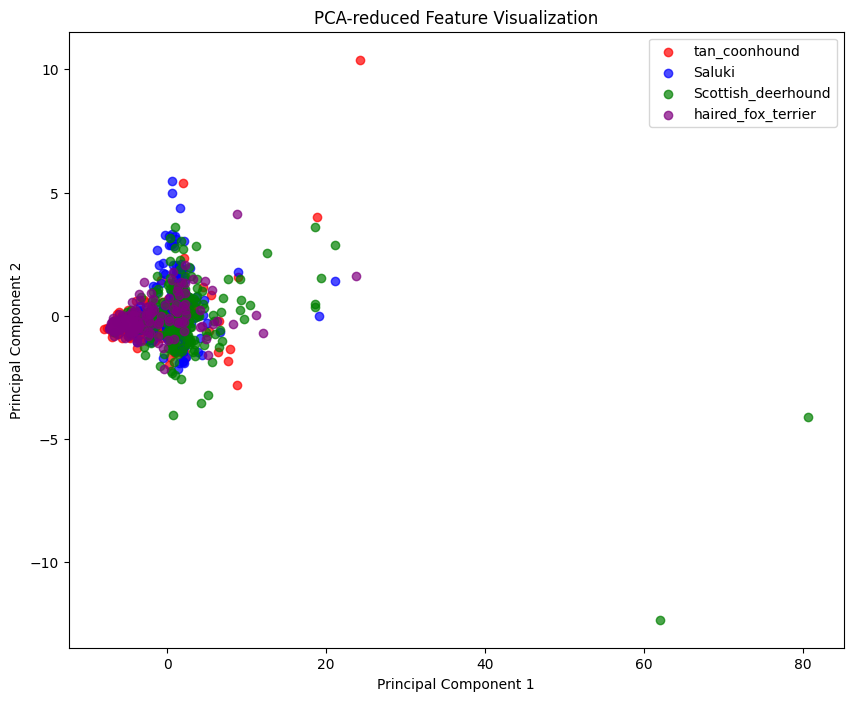

In [27]:
all_histograms = []
all_labels = []

for dog_breed in DogBreedClasses.BREED_CLASSES:
    breed_image_dir = os.path.join(DirectoryPaths.BASE_IMAGE_DIR, dog_breed)

    for image_file in os.listdir(breed_image_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(breed_image_dir, image_file)
            grayscale_image = np.array(Image.open(image_path).convert("L"))
            edge_angle = FeatureExtractor.calculate_edge_angle(grayscale_image)
            histogram, _ = FeatureExtractor.compute_edge_histogram(edge_angle)
            all_histograms.append(histogram)
            all_labels.append(dog_breed)

feature_matrix = np.array(all_histograms)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
colors = ["red", "blue", "green", "purple"]
for i, dog_breed in enumerate(DogBreedClasses.BREED_CLASSES):
    breed_mask = np.array(all_labels) == dog_breed
    plt.scatter(
        reduced_features[breed_mask, 0],
        reduced_features[breed_mask, 1],
        c=colors[i],
        label=DogBreedClasses.get_breed_labels()[i],
        alpha=0.7,
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA-reduced Feature Visualization")
plt.legend()
plt.show()


Based on the 2D visualization of the data points from the 4 classes, only 1
class appears to be visually separable (non-overlapping) from the others. The
red data points representing the "haired_fox_terrier" class are clustered
distinctly apart from the other 3 classes, which have significant overlap
amongst themselves in this reduced 2D feature space.


## 3. Text Processing on Tweet Dataset


In [28]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

with open("train.json", "r") as file:
    tweet_data = [json.loads(line) for line in file]

tweet_df = pd.DataFrame(tweet_data)


In [29]:
selected_emotions = ["anticipation", "disgust", "pessimism", "sadness"]
tweet_df["emotion"] = tweet_df[selected_emotions].idxmax(axis=1)
filtered_tweet_df = tweet_df[tweet_df[selected_emotions].sum(axis=1) == 1]

tweet_texts = filtered_tweet_df["Tweet"].values
tweet_emotions = filtered_tweet_df["emotion"].values

count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

count_features = count_vectorizer.fit_transform(tweet_texts)
tfidf_features = tfidf_vectorizer.fit_transform(tweet_texts)

count_feature_dim = count_features.shape[1]
tfidf_feature_dim = tfidf_features.shape[1]


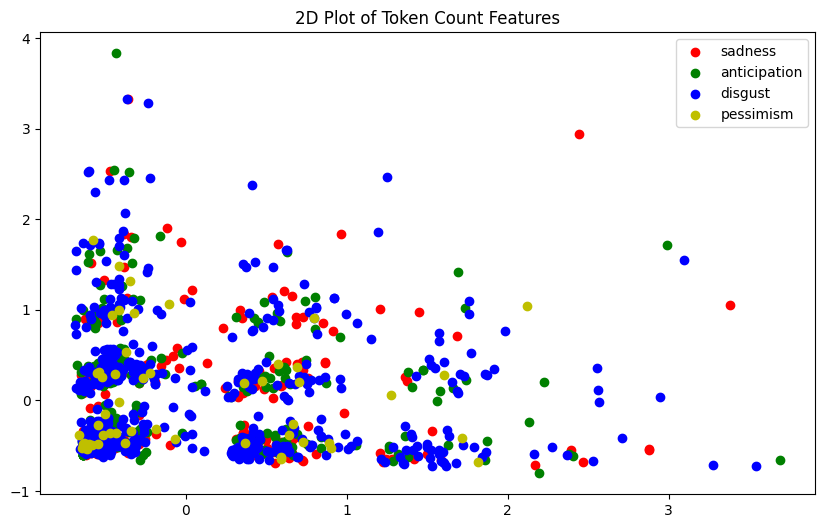

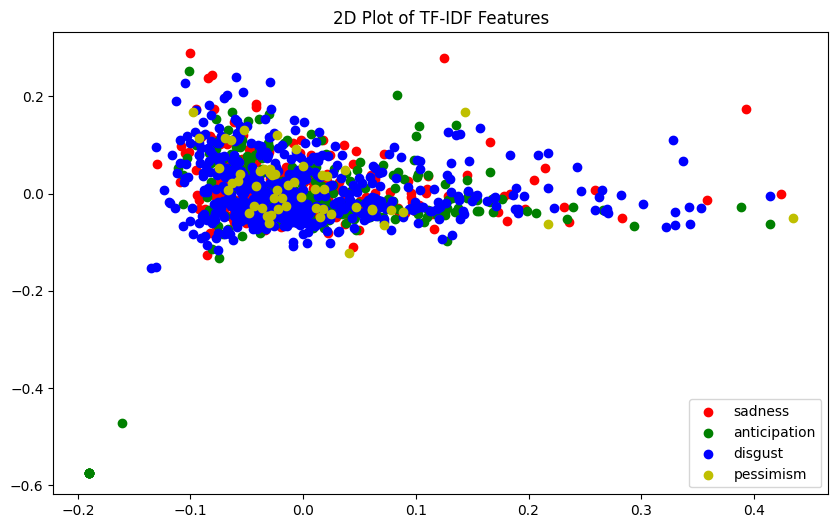

Dimensionality of token count features: 5299
Dimensionality of TF-IDF features: 5299


In [30]:
pca = PCA(n_components=2)
count_reduced_features = pca.fit_transform(count_features.toarray())
tfidf_reduced_features = pca.fit_transform(tfidf_features.toarray())


class FeatureVisualizer:
    @staticmethod
    def plot_reduced_features(reduced_features, labels, title):
        plt.figure(figsize=(10, 6))
        unique_labels = list(set(labels))
        colors = ["r", "g", "b", "y"]
        for i, label in enumerate(unique_labels):
            label_indices = [j for j, label_j in enumerate(labels) if label_j == label]
            plt.scatter(
                reduced_features[label_indices, 0],
                reduced_features[label_indices, 1],
                c=colors[i],
                label=label,
            )
        plt.title(title)
        plt.legend()
        plt.show()


FeatureVisualizer.plot_reduced_features(
    count_reduced_features, tweet_emotions, "2D Plot of Token Count Features"
)

FeatureVisualizer.plot_reduced_features(
    tfidf_reduced_features, tweet_emotions, "2D Plot of TF-IDF Features"
)

print(f"Dimensionality of token count features: {count_feature_dim}")
print(f"Dimensionality of TF-IDF features: {tfidf_feature_dim}")


For the `Token Count Features`, all 4 classes (pessimism, disgust, sadness,
anticipation) appear to be overlapping and not visually separable based on the
2D visualization of their token count features.

Similarly, `TF-IDF Features` also show that the data points from all 4 classes
are intermixed and overlapping. No class forms a distinct, separable cluster in
this 2D feature space representation either.

Therefore, in both of these visualizations, 0 classes are visually separable, as
there is significant overlap between all the classes when projected into these
two dimensions.
